## model loading and testing

In [1]:
import torch
import joblib
from datetime import datetime
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import yaml
from lume_model.utils import variables_from_yaml, variables_as_yaml
from lume_model.models import TorchModel, TorchModule

In [2]:
model_path = '/sdf/data/ad/ard/u/zihanzhu/ml/lcls_fel_tuning/model/'
# Specify the model foldel
model_version = '2024-04-08_06-02-49_nn/'

loaded_model_path = model_path + model_version + 'lcls_fel_model.pt'
loaded_input_scaler_path = model_path + model_version + 'lcls_fel_input_scaler.pt'
loaded_output_scaler_path = model_path + model_version + 'lcls_fel_output_scaler.pt'

# Load the model state dictionary
model = torch.load(loaded_model_path)

# Load the model state dictionary
input_scaler = torch.load(loaded_input_scaler_path)
output_scaler = torch.load(loaded_output_scaler_path)
# Load the input and output variables
input_variables, output_variables = variables_from_yaml(model_path + model_version + 'feature_config.yml')


## Create a LUME model to wrap input, output transformers and neural network intor TorchModule

In [3]:
# create TorchModel
lume_model = TorchModel(
    model=loaded_model_path,
    input_variables=input_variables,
    output_variables=output_variables,
    input_transformers=[input_scaler],
    output_transformers=[output_scaler],
)



In [4]:
# wrap in TorchModule
lume_module = TorchModule(
    model=lume_model,
    input_order=lume_model.input_names,
    output_order=lume_model.output_names,
)

lume_module

TorchModule(
  (base_model): Sequential(
    (0): Linear(in_features=42, out_features=256, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ELU(alpha=1.0)
    (4): Dropout(p=0.05, inplace=False)
    (5): Linear(in_features=128, out_features=64, bias=True)
    (6): ELU(alpha=1.0)
    (7): Dropout(p=0.05, inplace=False)
    (8): Linear(in_features=64, out_features=16, bias=True)
    (9): ELU(alpha=1.0)
    (10): Dropout(p=0.05, inplace=False)
    (11): Linear(in_features=16, out_features=16, bias=True)
    (12): ELU(alpha=1.0)
    (13): Linear(in_features=16, out_features=1, bias=True)
  )
  (input_transformers_0): AffineInputTransform()
  (output_transformers_0): AffineInputTransform()
)

## Test model performance 

In [5]:
def dataset_filter(dataset):
    # Filtering based on multiple conditions
    condition = (dataset['ACCL:LI21:1:L1S_S_PV'] < 0) &  \
                (dataset['XRMS on VCC'] > 300) & (dataset['XRMS on VCC'] < 350) & \
                (dataset['YRMS on VCC'] > 300) & (dataset['YRMS on VCC'] < 350) & \
                (dataset['hxr_pulse_intensity'] > 0.02) & (dataset['hxr_pulse_intensity'] < 3) & \
                (dataset['Bunch length at BC1'] > 200) & (dataset['Bunch length at BC1'] < 300) & \
                (dataset['Bunch length at BC2'] > 3e3) & (dataset['Bunch length at BC2'] < 1e5) & \
                (dataset['Charge at gun [pC]'] > 240) & (dataset['Charge at gun [pC]'] < 260) & \
                (dataset['Charge after BC1 [pC]'] < 200) & \
                (dataset['HXR electron energy [GeV]'] > 10) & (dataset['HXR photon energy [eV]'] > 900)
                # all_df['hxr_pulse_intensity'] > 0.05)
    return dataset[condition]

In [6]:
# get testing samples from dataset
test_set = dataset_filter(pd.read_pickle('/sdf/data/ad/ard/u/zihanzhu/ml/lcls_fel_tuning/dataset/hxr_archiver_Jan_latest.pkl'))

# Define the fractions of the total number of rows for the selected validation set
selected_ranges = [(0.55, 0.7)]

selected_validation_set = pd.DataFrame()
for start_fraction, end_fraction in selected_ranges:
    start_index = int(start_fraction * len(test_set))
    end_index = int(end_fraction * len(test_set))
    subset = test_set.iloc[start_index:end_index]
    selected_validation_set = pd.concat([selected_validation_set, subset])
input_data = torch.tensor(selected_validation_set[lume_model.input_names].values)
model_output = lume_module(input_data)
ground_truth = selected_validation_set[lume_model.output_names]

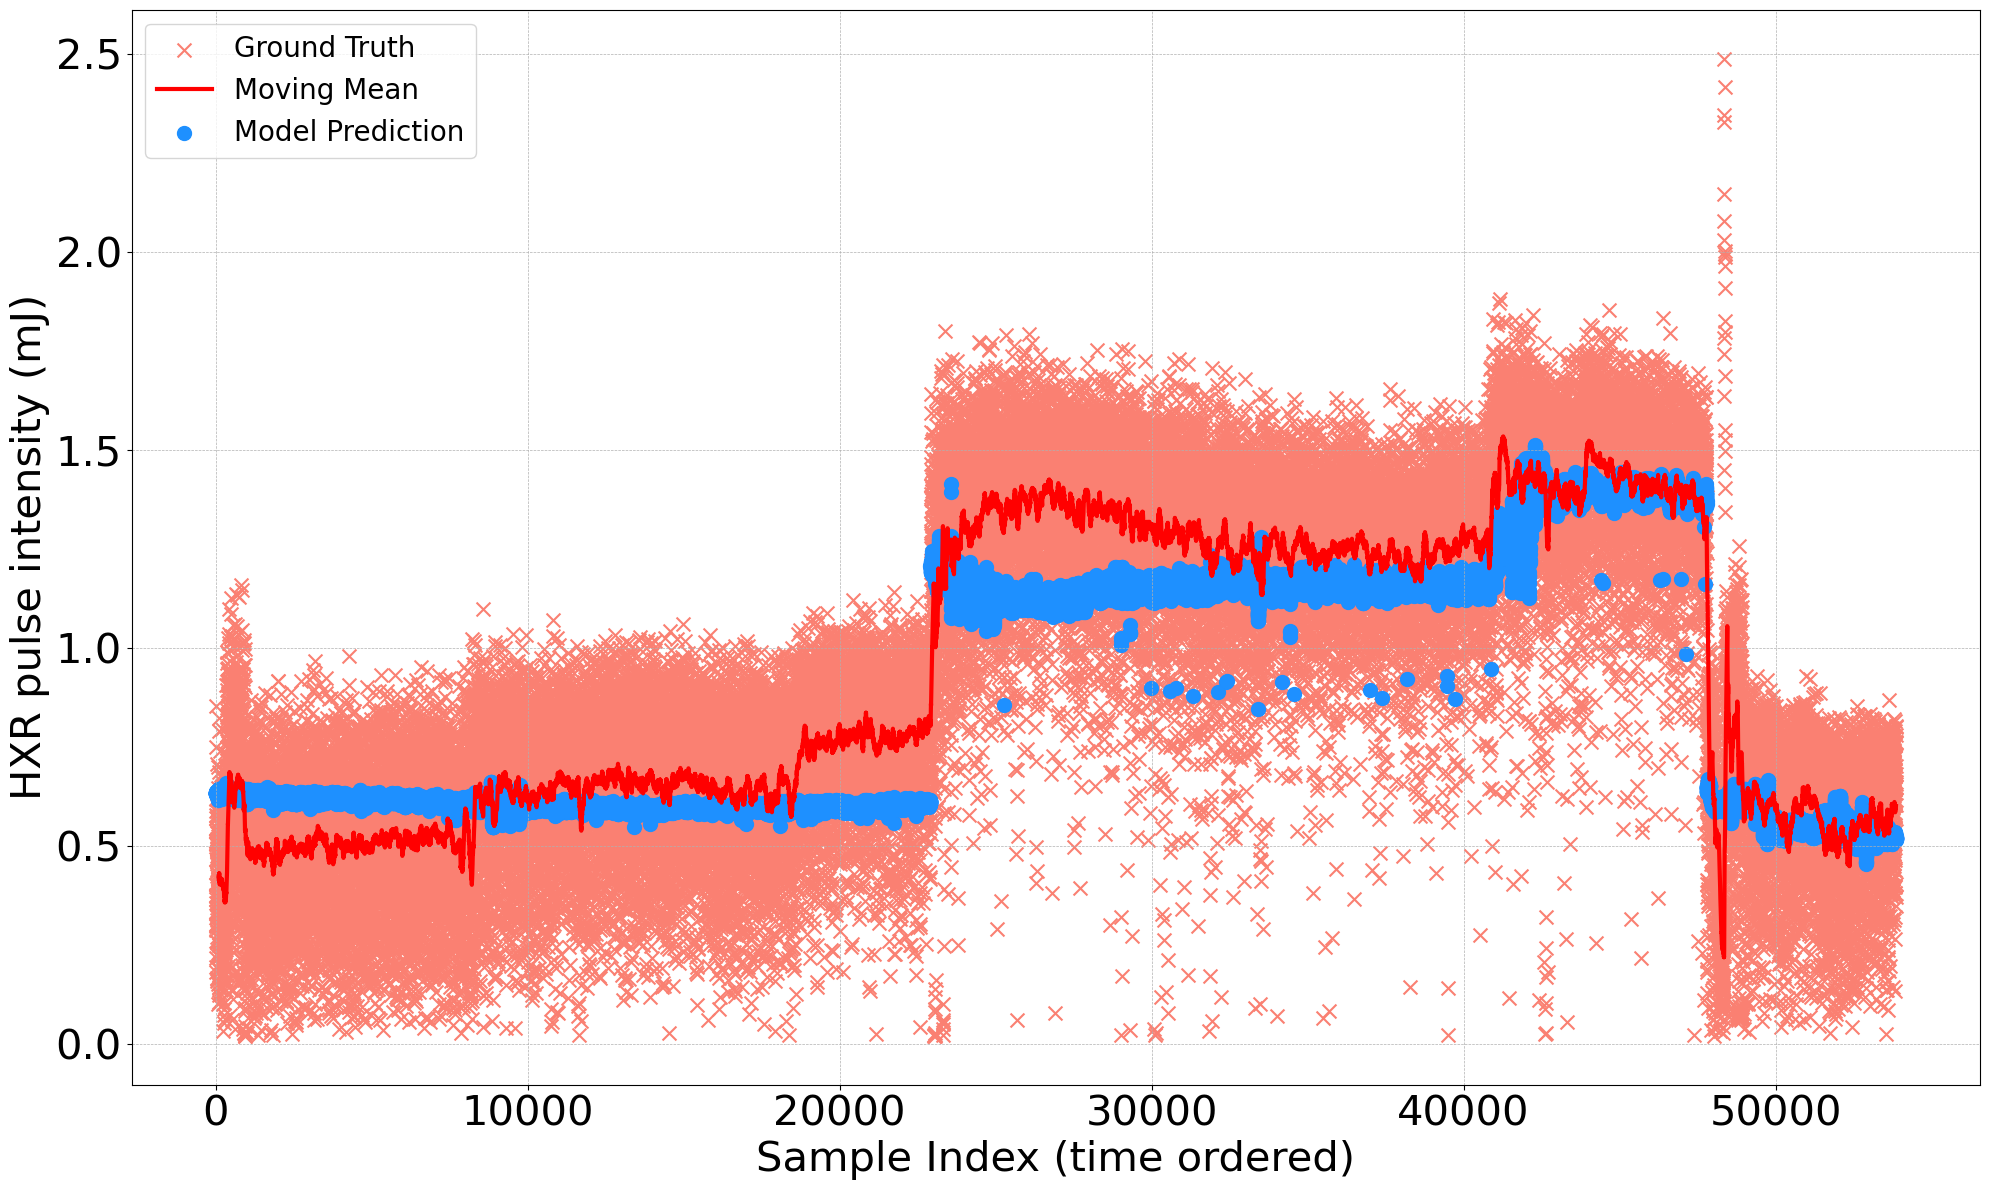

In [7]:
fontsize = 30
plt.figure(figsize=(20,12))
window_size = 100

moving_avg = ground_truth.rolling(window=window_size).mean()
shot_axis = np.arange(selected_validation_set.shape[0])
plt.scatter(shot_axis, ground_truth, label='Ground Truth', color='salmon', marker='x',s=100)
plt.plot(shot_axis, moving_avg, label='Moving Mean', color='red', linewidth=3)
plt.scatter(shot_axis, model_output, label='Model Prediction', color='dodgerblue', marker='o', s=100)
plt.xlabel('Sample Index (time ordered)', fontsize=fontsize)
plt.ylabel('HXR pulse intensity (mJ)',fontsize=fontsize)
# plt.xlim([0, num_samples_to_plot])
# plt.ylim([-2.2, 2.2])
plt.legend(fontsize=20, loc='upper left')
plt.tick_params(labelsize=fontsize)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()